In [1]:
# import os
# import glob

import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

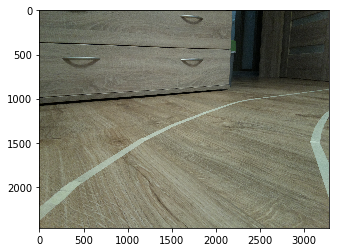

In [69]:
TEST_IMG = ".\\images\\cam.jpg"
lane_test_img = cv2.imread(TEST_IMG)
lane_test_img_rgb = cv2.cvtColor(lane_test_img, cv2.COLOR_BGR2RGB)

plt.imshow(lane_test_img_rgb)

In [70]:
# GRADIENT_THRESH = (20, 100)
# S_CHANNEL_THRESH = (80, 255)
# L_CHANNEL_THRESH = (80, 255)
# B_CHANNEL_THRESH = (150, 200)
# L2_CHANNEL_THRESH = (225, 255)

GRADIENT_THRESH = (10, 50)
S_CHANNEL_THRESH = (20, 155)
L_CHANNEL_THRESH = (20, 155)
B_CHANNEL_THRESH = (150, 200)
A_CHANNEL_THRESH = (120, 255)
L2_CHANNEL_THRESH = (145, 255)

In [71]:
def seperate_hls(rgb_img):
    hls = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HLS)
    h = hls[:,:,0]
    l = hls[:,:,1]
    s = hls[:,:,2]
    return h, l, s

def seperate_lab(rgb_img):
    lab = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2Lab)
    l = lab[:,:,0]
    a = lab[:,:,1]
    b = lab[:,:,2]
    return l, a, b

def seperate_luv(rgb_img):
    luv = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2Luv)
    l = luv[:,:,0]
    u = luv[:,:,1]
    v = luv[:,:,2]
    return l, u, v

def binary_threshold_lab_luv(rgb_img, bthresh, lthresh):
    l, a, b = seperate_lab(rgb_img)
    l2, u, v = seperate_luv(rgb_img)
    binary = np.zeros_like(l)
    binary[
        ((b > bthresh[0]) & (b <= bthresh[1])) |
        ((l2 > lthresh[0]) & (l2 <= lthresh[1]))
    ] = 1
    return binary

def binary_threshold_lab_luv_2(rgb_img, athresh, lthresh):
    l, a, b = seperate_lab(rgb_img)
    l2, u, v = seperate_luv(rgb_img)
    binary = np.ones_like(l)
    binary[
        (a > athresh[0]) & (a <= athresh[1])
    ] = 0
    return binary

def binary_threshold_hls(rgb_img, sthresh, lthresh):
    h, l, s = seperate_hls(rgb_img)
    binary = np.zeros_like(h)
    binary[
        ((s > sthresh[0]) & (s <= sthresh[1])) &
        ((l > lthresh[0]) & (l <= lthresh[1]))
    ] = 1
    return binary

def gradient_threshold(channel, thresh):
    # Take the derivative in x
    sobelx = cv2.Sobel(channel, cv2.CV_64F, 1, 0)
    # Absolute x derivative to accentuate lines away from horizontal
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Threshold gradient channel
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sxbinary

(-0.5, 3279.5, 2463.5, -0.5)

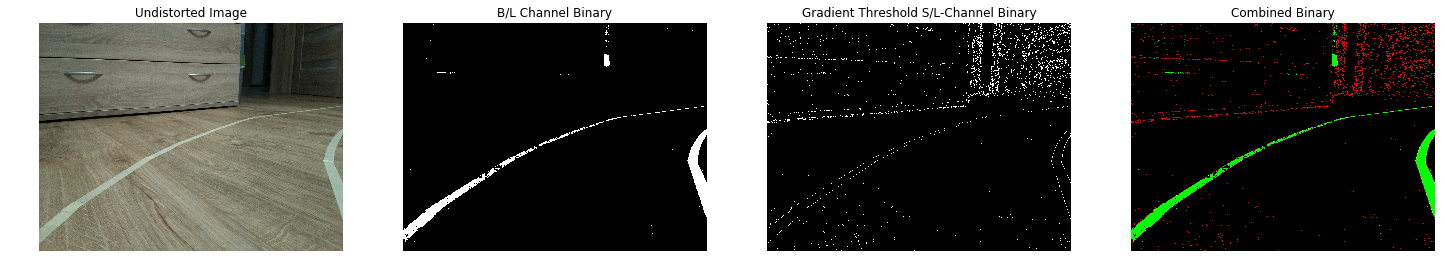

In [72]:
# LAB and LUV channel threshold
s_binary = binary_threshold_lab_luv_2(lane_test_img_rgb, A_CHANNEL_THRESH, L2_CHANNEL_THRESH)

# Gradient threshold on S channel
h, l, s = seperate_hls(lane_test_img_rgb)
sxbinary = gradient_threshold(h, GRADIENT_THRESH)

# Combine two binary images to view their contribution in green and red
color_binary = np.dstack((sxbinary, s_binary, np.zeros_like(sxbinary))) * 255

# Draw figure for binary images
f, axarr = plt.subplots(1,4)
f.set_size_inches(25, 8)
axarr[0].imshow(lane_test_img_rgb)
axarr[1].imshow(s_binary, cmap='gray')
axarr[2].imshow(sxbinary, cmap='gray')
axarr[3].imshow(color_binary)
axarr[0].set_title("Undistorted Image")
axarr[1].set_title("B/L Channel Binary")
axarr[2].set_title("Gradient Threshold S/L-Channel Binary")
axarr[3].set_title("Combined Binary")
axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('off')
axarr[3].axis('off')

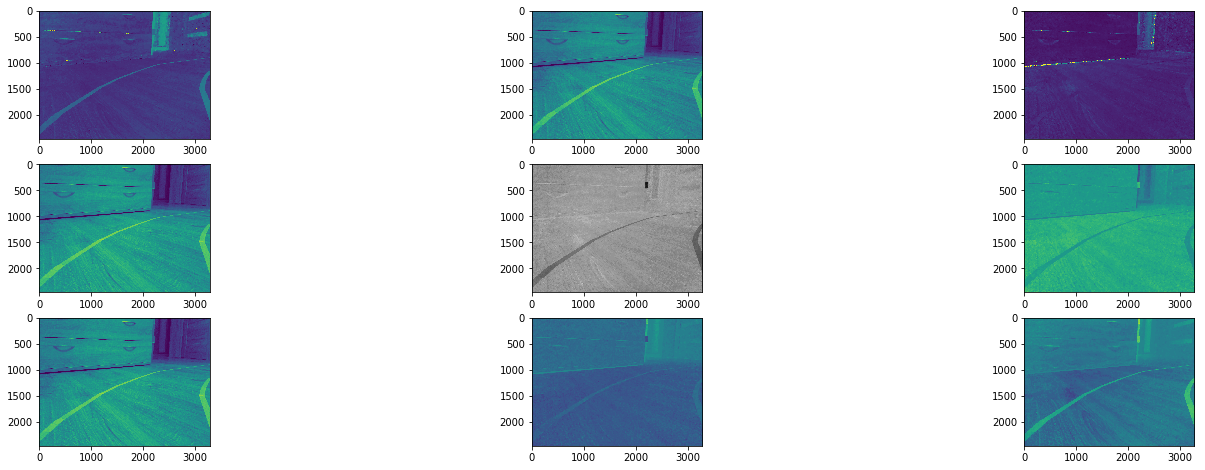

In [73]:
h, l, s = seperate_hls(lane_test_img_rgb)

l2, a2, b2 = seperate_lab(lane_test_img_rgb)

l3, u3, v3 = seperate_luv(lane_test_img_rgb)

f, axarr = plt.subplots(3,3)
f.set_size_inches(25, 8)
axarr[0, 0].imshow(h)
axarr[0, 1].imshow(l)
axarr[0, 2].imshow(s)

axarr[1, 0].imshow(l2)
axarr[1, 1].imshow(a2, cmap='gray')
axarr[1, 2].imshow(b2)

axarr[2, 0].imshow(l3)
axarr[2, 1].imshow(u3)
axarr[2, 2].imshow(v3)

In [74]:
IMG_SIZE = lane_test_img_rgb.shape[::-1][1:]
OFFSET = 300

PRES_SRC_PNTS = np.float32([
    (IMG_SIZE[0]*0.02, IMG_SIZE[1]*0.4), # Top-left corner
    (1, IMG_SIZE[1]), # Bottom-left corner
    (IMG_SIZE[0], IMG_SIZE[1]), # Bottom-right corner
    (IMG_SIZE[0]*0.97, IMG_SIZE[1]*0.4) # Top-right corner
])

PRES_DST_PNTS = np.float32([
    [OFFSET, 0], 
    [OFFSET, IMG_SIZE[1]],
    [IMG_SIZE[0]-OFFSET, IMG_SIZE[1]], 
    [IMG_SIZE[0]-OFFSET, 0]
])

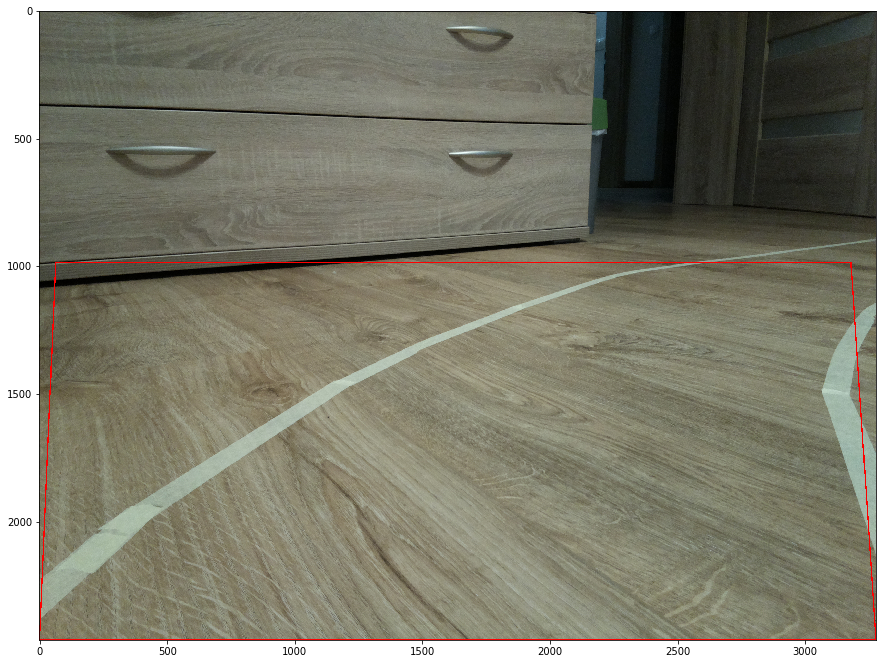

In [75]:
lane_test_undist_cp = lane_test_img_rgb.copy()
plt.figure(figsize = (15, 15))
plt.imshow(cv2.polylines(lane_test_undist_cp, np.int32([PRES_SRC_PNTS]), True, (255,0,0), 3));

In [76]:
M = cv2.getPerspectiveTransform(PRES_SRC_PNTS, PRES_DST_PNTS)
M_INV = cv2.getPerspectiveTransform(PRES_DST_PNTS, PRES_SRC_PNTS)
warped = cv2.warpPerspective(lane_test_img_rgb, M, IMG_SIZE, flags=cv2.INTER_LINEAR)

Text(0.5,1,'Warped result with destination points Drawn')

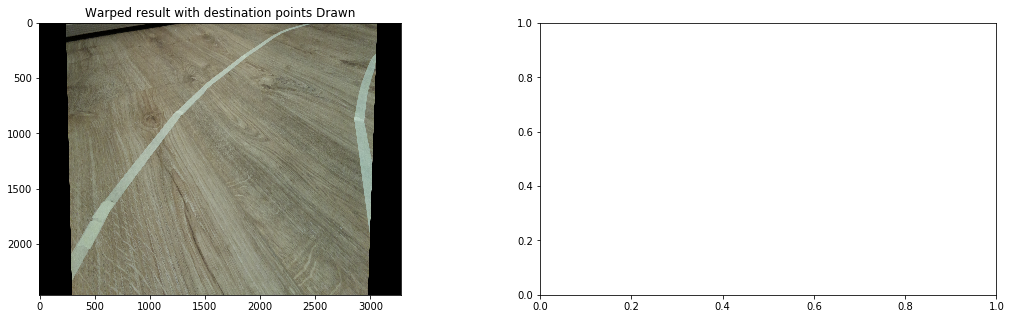

In [77]:
warped_cp = warped.copy()
warped_poly = cv2.polylines(warped_cp, np.int32([PRES_DST_PNTS]), True, (255,0,0), 3)

# Draw figure for the two warped lane lines
f, axarr = plt.subplots(1,2)
f.set_size_inches(18, 5)
axarr[0].imshow(warped_poly)
axarr[0].set_title("Warped result with destination points Drawn")

In [78]:
N_WINDOWS = 50
MARGIN = 300
RECENTER_MINPIX = 50

# Define conversions in x and y from pixels space to meters
YM_PER_PIX = 30 / 720 # meters per pixel in y dimension
XM_PER_PIX = 3.7 / 700 # meters per pixel in x dimension

In [79]:
def histo_peak(histo):
    """Find left and right peaks of histogram"""
    midpoint = np.int(histo.shape[0]/2)
    leftx_base = np.argmax(histo[:midpoint])
    rightx_base = np.argmax(histo[midpoint:]) + midpoint
    return leftx_base, rightx_base

def get_lane_indices_sliding_windows(binary_warped, leftx_base, rightx_base, n_windows, margin, recenter_minpix):
    """Get lane line pixel indices by using sliding window technique"""
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img = out_img.copy()
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/n_windows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    for window in range(n_windows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > recenter_minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > recenter_minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    return left_lane_inds, right_lane_inds, nonzerox, nonzeroy, out_img

def get_lane_indices_from_prev_window(binary_warped_img, left_fit, right_fit, margin):
    """Detect lane line by searching around detection of previous sliding window detection"""
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_lane_inds, right_lane_inds, ploty, left_fitx, right_fitx

Text(0.5,1,'Histogram of Lane line Pixels')

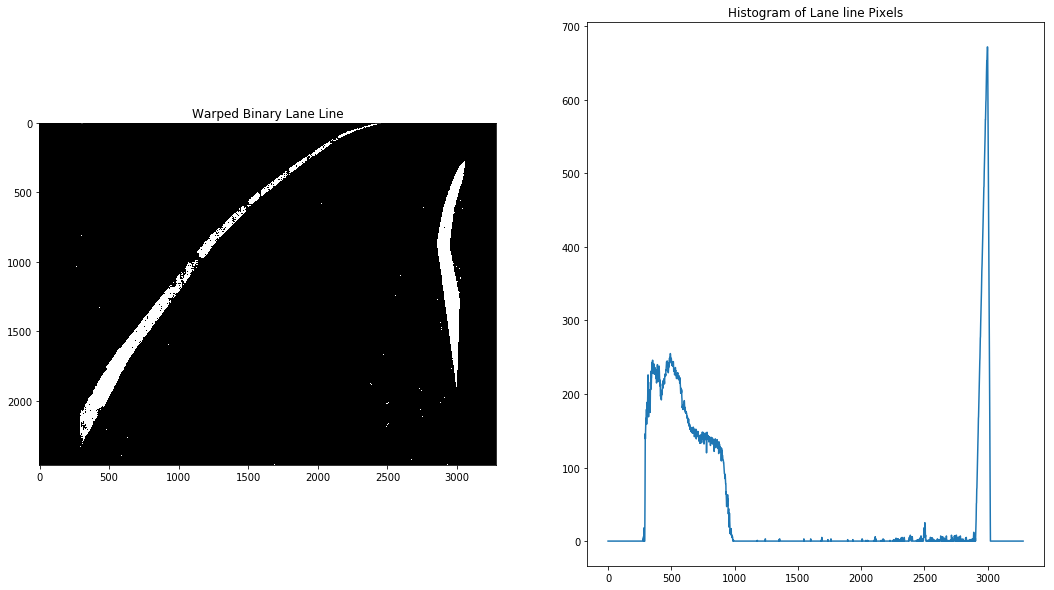

In [80]:
# Warp binary image of lane line
binary_warped = cv2.warpPerspective(s_binary, M, IMG_SIZE, flags=cv2.INTER_LINEAR)

# Calculate histogram of lane line pixels
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)

# Draw figure for warped binary and histogram
f, axarr = plt.subplots(1,2)
f.set_size_inches(18, 10)
axarr[0].imshow(binary_warped, cmap='gray')
axarr[1].plot(histogram)
axarr[0].set_title("Warped Binary Lane Line")
axarr[1].set_title("Histogram of Lane line Pixels")

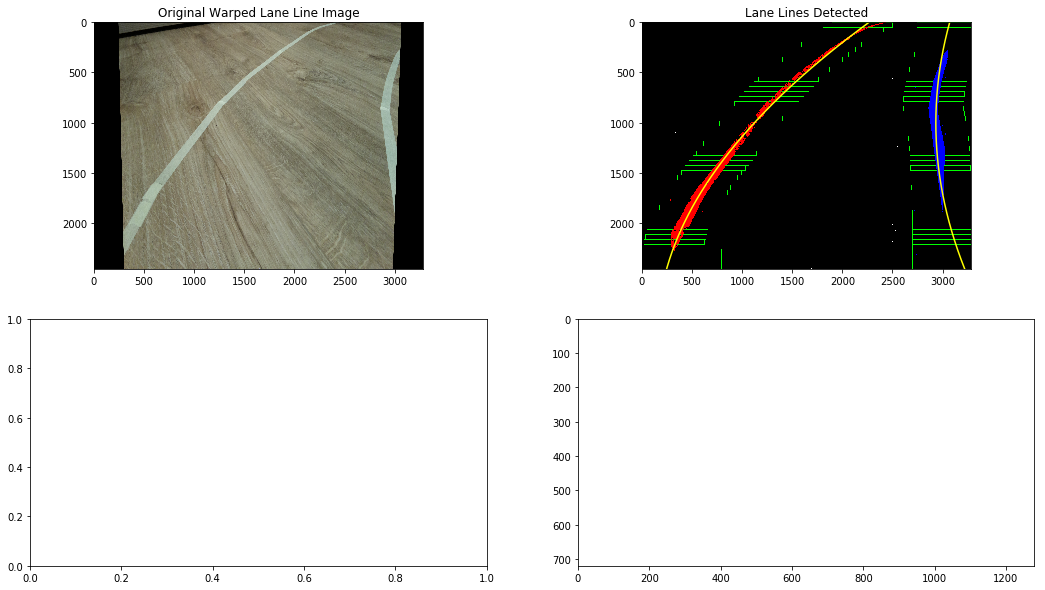

In [81]:
leftx_base, rightx_base = histo_peak(histogram)
left_lane_inds, right_lane_inds, nonzerox, nonzeroy, out_img = get_lane_indices_sliding_windows(
    binary_warped, leftx_base, rightx_base, N_WINDOWS, MARGIN, RECENTER_MINPIX)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Draw figures of line lanes detected
f, axarr = plt.subplots(2,2)
f.set_size_inches(18, 10)
axarr[0, 0].imshow(warped_cp)
axarr[0, 1].imshow(out_img)
axarr[0, 1].plot(left_fitx, ploty, color='yellow')
axarr[0, 1].plot(right_fitx, ploty, color='yellow')
axarr[0, 0].set_title("Original Warped Lane Line Image")
axarr[0, 1].set_title("Lane Lines Detected");
plt.xlim(0, 1280)
plt.ylim(720, 0);

In [82]:
left_lane_inds, right_lane_inds, ploty, left_fitx, right_fitx = get_lane_indices_from_prev_window(
    binary_warped, left_fit, right_fit, MARGIN)

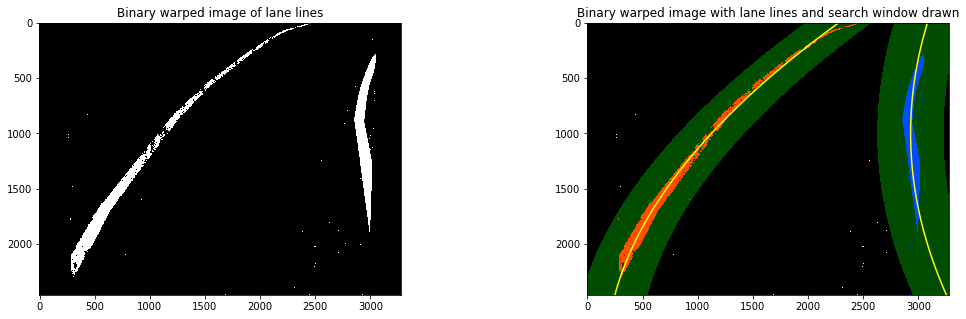

In [83]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-MARGIN, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+MARGIN, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-MARGIN, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+MARGIN, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

# Plot the figure
f, axarr = plt.subplots(1,2)
f.set_size_inches(18, 5)
axarr[0].imshow(binary_warped, cmap='gray')
axarr[1].imshow(result)
axarr[1].plot(left_fitx, ploty, color='yellow')
axarr[1].plot(right_fitx, ploty, color='yellow')
axarr[0].set_title("Binary warped image of lane lines")
axarr[1].set_title("Binary warped image with lane lines and search window drawn");

In [84]:
def project_lane_line(original_image, binary_warped, ploty, left_fitx, right_fitx, m_inv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, m_inv, (original_image.shape[1], original_image.shape[0]))
    
    # Combine the result with the original image
    result = cv2.addWeighted(original_image, 1, newwarp, 0.3, 0)
    return result

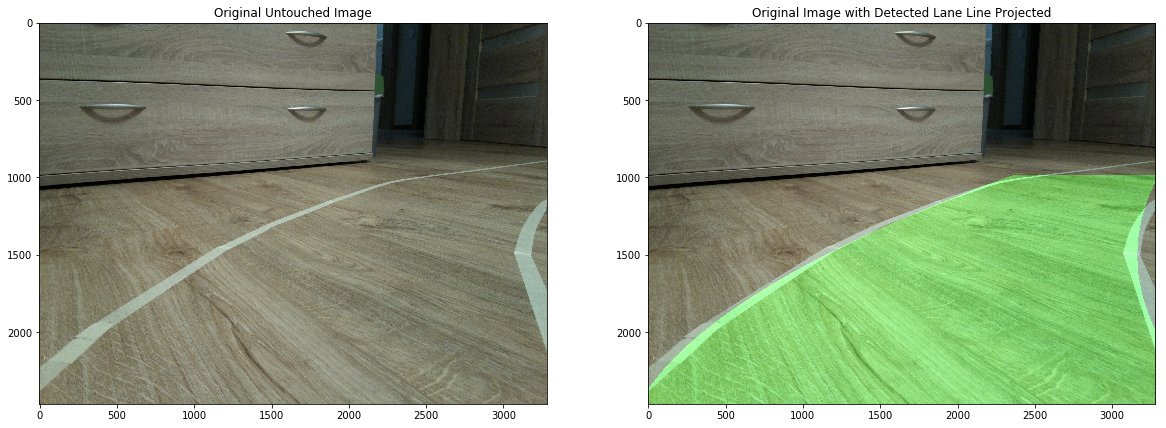

In [85]:
result = project_lane_line(lane_test_img_rgb, binary_warped, ploty, left_fitx, right_fitx, M_INV)

# Plot original image and original image with lane line projected
f, axarr = plt.subplots(1,2)
f.set_size_inches(20, 8)
axarr[0].imshow(lane_test_img_rgb, cmap='gray')
axarr[1].imshow(result)
axarr[0].set_title("Original Untouched Image")
axarr[1].set_title("Original Image with Detected Lane Line Projected");

In [86]:
def calc_curvature(ploty, leftx, rightx, lefty, righty, unit="m"):
    """returns curvature in meters."""
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*YM_PER_PIX, leftx*XM_PER_PIX, 2)
    right_fit_cr = np.polyfit(righty*YM_PER_PIX, rightx*XM_PER_PIX, 2)
    # Calculate the new radii of curvature
    left_curvem = ((1 + (2*left_fit_cr[0]*y_eval*YM_PER_PIX + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curvem = ((1 + (2*right_fit_cr[0]*y_eval*YM_PER_PIX + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return left_curvem, right_curvem

In [87]:
left_curvem, right_curvem = calc_curvature(ploty, leftx, rightx, lefty, righty)
print(left_curvem, 'm', right_curvem, 'm')

749.3090527971485 m 1209.2619914487586 m
